# Regularized Linear Regression Project Tutorial

**Objetivo de la tarea:** Descubrir si hay una relación entre recursos para la salud y datos sociodemográficos. Se debe elegir una variable target (relacionada a la salud) y utilizar LASSO para seleccionar las variables explicativas más importantes.

También hay que encontrar los coeficientes seleccionados para el modelo final.


**STEP 1:** Cargar los datos

Primero ejecutar en consola `pip install -r requirements.txt`

In [101]:
# librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import statsmodels.formula.api as smf
import seaborn as sns 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pickle


In [3]:
# cargo datos
df_raw = pd.read_csv('https://raw.githubusercontent.com/4GeeksAcademy/regularized-linear-regression-project-tutorial/main/dataset.csv')

In [4]:
pd.set_option('display.max_columns',110)

In [5]:
df_raw.info(verbose = True, show_counts = True)
# abro en editor de texto para verlo completo

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3140 entries, 0 to 3139
Data columns (total 108 columns):
 #    Column                                                                         Non-Null Count  Dtype  
---   ------                                                                         --------------  -----  
 0    fips                                                                           3140 non-null   int64  
 1    TOT_POP                                                                        3140 non-null   int64  
 2    0-9                                                                            3140 non-null   int64  
 3    0-9 y/o % of total pop                                                         3140 non-null   float64
 4    19-Oct                                                                         3140 non-null   int64  
 5    10-19 y/o % of total pop                                                       3140 non-null   float64
 6    20-29         

El data frame contiene 3140 filas (observaciones) y 108 columnas (variables). Las variables se interpretan con el diccionario. La mayoría de las variables son numéricas (int o float), estas deben ser categóricas:
* fips
* COUNTY_NAME
* STATE_NAME
* STATE_FIPS
* CNTY_FIPS
* Urban_rural_code

No hay datos faltantes.

Hay que cambiar el nombre de una variable: '19-Oct' es en realidad '10-19'

In [6]:
df_raw.rename(columns = {'19-Oct':'10-19'}, inplace = True)

In [7]:
df_raw.sample(5)

,fips,TOT_POP,0-9,0-9 y/o % of total pop,10-19,10-19 y/o % of total pop,20-29,20-29 y/o % of total pop,30-39,30-39 y/o % of total pop,40-49,40-49 y/o % of total pop,50-59,50-59 y/o % of total pop,60-69,60-69 y/o % of total pop,70-79,70-79 y/o % of total pop,80+,80+ y/o % of total pop,White-alone pop,% White-alone,Black-alone pop,% Black-alone,Native American/American Indian-alone pop,% NA/AI-alone,Asian-alone pop,% Asian-alone,Hawaiian/Pacific Islander-alone pop,% Hawaiian/PI-alone,Two or more races pop,% Two or more races,POP_ESTIMATE_2018,N_POP_CHG_2018,GQ_ESTIMATES_2018,R_birth_2018,R_death_2018,R_NATURAL_INC_2018,R_INTERNATIONAL_MIG_2018,R_DOMESTIC_MIG_2018,R_NET_MIG_2018,Less than a high school diploma 2014-18,High school diploma only 2014-18,Some college or associate's degree 2014-18,Bachelor's degree or higher 2014-18,Percent of adults with less than a high school diploma 2014-18,Percent of adults with a high school diploma only 2014-18,Percent of adults completing some college or associate's degree 2014-18,Percent of adults with a bachelor's degree or higher 2014-18,POVALL_2018,PCTPOVALL_2018,PCTPOV017_2018,PCTPOV517_2018,MEDHHINC_2018,CI90LBINC_2018,CI90UBINC_2018,Civilian_labor_force_2018,Employed_2018,Unemployed_2018,Unemployment_rate_2018,Median_Household_Income_2018,Med_HH_Income_Percent_of_State_Total_2018,Active Physicians per 100000 Population 2018 (AAMC),Total Active Patient Care Physicians per 100000 Population 2018 (AAMC),Active Primary Care Physicians per 100000 Population 2018 (AAMC),Active Patient Care Primary Care Physicians per 100000 Population 2018 (AAMC),Active General Surgeons per 100000 Population 2018 (AAMC),Active Patient Care General Surgeons per 100000 Population 2018 (AAMC),Total nurse practitioners (2019),Total physician assistants (2019),Total Hospitals (2019),Internal Medicine Primary Care (2019),Family Medicine/General Practice Primary Care (2019),Total Specialist Physicians (2019),ICU Beds_x,Total Population,Population Aged 60+,Percent of Population Aged 60+,COUNTY_NAME,STATE_NAME,STATE_FIPS,CNTY_FIPS,county_pop2018_18 and older,anycondition_prevalence,anycondition_Lower 95% CI,anycondition_Upper 95% CI,anycondition_number,Obesity_prevalence,Obesity_Lower 95% CI,Obesity_Upper 95% CI,Obesity_number,Heart disease_prevalence,Heart disease_Lower 95% CI,Heart disease_Upper 95% CI,Heart disease_number,COPD_prevalence,COPD_Lower 95% CI,COPD_Upper 95% CI,COPD_number,diabetes_prevalence,diabetes_Lower 95% CI,diabetes_Upper 95% CI,diabetes_number,CKD_prevalence,CKD_Lower 95% CI,CKD_Upper 95% CI,CKD_number,Urban_rural_code
450,13133,17698,1848,10.441858,1717,9.701661,1597,9.023618,1827,10.323200,1733,9.792067,2283,12.899763,3145,17.770370,2643,14.933891,905,5.113572,11175,63.142728,5998,33.890835,102,0.576336,183,1.034015,24,0.135609,216,1.220477,17698,478,200,8.8,13.4,-4.6,1.5,30.3,31.8,2133,4259,2998,3273,16.8,33.6,23.7,25.8,3365,19.3,35.4,33.4,54016,48637,59395,6994,6697,297,4.2,54016,92.1,228.7,202.9,79.1,71.9,7.0,6.1,8.100772,5.597356,0.243948,8.375004,5.738678,21.514574,0,16732,6034,36.1,Greene,Georgia,13,133,14396,52.2,50.0,54.4,7519,33.5,31.9,35.0,4823,11.3,10.1,12.4,1623,11.4,9.7,13.2,1638,18.0,16.7,19.4,2595,4.6,4.3,4.9,661,6
2019,38063,2869,301,10.491460,300,10.456605,245,8.539561,274,9.550366,263,9.166957,439,15.301499,489,17.044266,321,11.188567,237,8.260718,2731,95.189962,24,0.836528,52,1.812478,7,0.243987,1,0.034855,54,1.882189,2869,-40,79,9.3,17.3,-8.0,0.3,-5.9,-5.5,183,681,840,499,8.3,30.9,38.1,22.7,301,10.8,11.2,9.6,50093,44721,55465,1425,1377,48,3.4,50093,76.8,237.6,217.1,87.0,79.6,10.5,9.7,1.725000,0.856838,0.147210,1.324891,2.215701,3.408480,0,2971,1067,35.9,Nelson,North Dakota,38,63,2315,49.9,47.1,52.3,1154,38.3,36.4,40.4,887,9.6,8.5,10.7,222,7.9,6.5,9.3,182,12.8,11.5,14.1,297,3.6,3.3,4.0,84,6
508,13251,13938,1652,11.852490,1547,11.099153,1822,13.072177,1561,11.199598,1633,11.716172,2031,14.571675,2001,14.356436,1146,8.222127,545,3.910174,7837,56.227579,5760,41.325872,65,0.4663

In [8]:
# guardo datos iniciales
df_raw.to_csv('../data/raw/datos_iniciales.csv', index = False)

**STEP 2:** Análisis exploratorio

In [40]:
# copio datos a otro data frame con el cual trabajar
df = df_raw.copy()

In [41]:
# convierto a la clase correspondiente las categóricas
df.fips = pd.Categorical(df.fips)
df.COUNTY_NAME = pd.Categorical(df.COUNTY_NAME)
df.STATE_NAME = pd.Categorical(df.STATE_NAME)
df.STATE_FIPS = pd.Categorical(df.STATE_FIPS)
df.CNTY_FIPS = pd.Categorical(df.CNTY_FIPS)
df.Urban_rural_code = pd.Categorical(df.Urban_rural_code)

In [42]:
# resumen numéricas
df.describe()

,TOT_POP,0-9,0-9 y/o % of total pop,10-19,10-19 y/o % of total pop,20-29,20-29 y/o % of total pop,30-39,30-39 y/o % of total pop,40-49,40-49 y/o % of total pop,50-59,50-59 y/o % of total pop,60-69,60-69 y/o % of total pop,70-79,70-79 y/o % of total pop,80+,80+ y/o % of total pop,White-alone pop,% White-alone,Black-alone pop,% Black-alone,Native American/American Indian-alone pop,% NA/AI-alone,Asian-alone pop,% Asian-alone,Hawaiian/Pacific Islander-alone pop,% Hawaiian/PI-alone,Two or more races pop,% Two or more races,POP_ESTIMATE_2018,N_POP_CHG_2018,GQ_ESTIMATES_2018,R_birth_2018,R_death_2018,R_NATURAL_INC_2018,R_INTERNATIONAL_MIG_2018,R_DOMESTIC_MIG_2018,R_NET_MIG_2018,Less than a high school diploma 2014-18,High school diploma only 2014-18,Some college or associate's degree 2014-18,Bachelor's degree or higher 2014-18,Percent of adults with less than a high school diploma 2014-18,Percent of adults with a high school diploma only 2014-18,Percent of adults completing some college or associate's degree 2014-18,Percent of adults with a bachelor's degree or higher 2014-18,POVALL_2018,PCTPOVALL_2018,PCTPOV017_2018,PCTPOV517_2018,MEDHHINC_2018,CI90LBINC_2018,CI90UBINC_2018,Civilian_labor_force_2018,Employed_2018,Unemployed_2018,Unemployment_rate_2018,Median_Household_Income_2018,Med_HH_Income_Percent_of_State_Total_2018,Active Physicians per 100000 Population 2018 (AAMC),Total Active Patient Care Physicians per 100000 Population 2018 (AAMC),Active Primary Care Physicians per 100000 Population 2018 (AAMC),Active Patient Care Primary Care Physicians per 100000 Population 2018 (AAMC),Active General Surgeons per 100000 Population 2018 (AAMC),Active Patient Care General Surgeons per 100000 Population 2018 (AAMC),Total nurse practitioners (2019),Total physician assistants (2019),Total Hospitals (2019),Internal Medicine Primary Care (2019),Family Medicine/General Practice Primary Care (2019),Total Specialist Physicians (2019),ICU Beds_x,Total Population,Population Aged 60+,Percent of Population Aged 60+,county_pop2018_18 and older,anycondition_prevalence,anycondition_Lower 95% CI,anycondition_Upper 95% CI,anycondition_number,Obesity_prevalence,Obesity_Lower 95% CI,Obesity_Upper 95% CI,Obesity_number,Heart disease_prevalence,Heart disease_Lower 95% CI,Heart disease_Upper 95% CI,Heart disease_number,COPD_prevalence,COPD_Lower 95% CI,COPD_Upper 95% CI,COPD_number,diabetes_prevalence,diabetes_Lower 95% CI,diabetes_Upper 95% CI,diabetes_number,CKD_prevalence,CKD_Lower 95% CI,CKD_Upper 95% CI,CKD_number
count,3.140000e+03,3.140000e+03,3140.000000,3.140000e+03,3140.000000,3.140000e+03,3140.000000,3.140000e+03,3140.000000,3.140000e+03,3140.000000,3.140000e+03,3140.000000,3.140000e+03,3140.000000,3140.000000,3140.000000,3140.000000,3140.000000,3.140000e+03,3140.000000,3.140000e+03,3140.000000,3140.000000,3140.000000,3.140000e+03,3140.000000,3140.000000,3140.000000,3140.000000,3140.000000,3.140000e+03,3140.000000,3140.000000,3140.000000,3140.000000,3140.000000,3140.000000,3140.000000,3140.000000,3.140000e+03,3.140000e+03,3.140000e+03,3.140000e+03,3140.000000,3140.000000,3140.000000,3140.000000,3.140000e+03,3140.000000,3140.000000,3140.000000,3140.000000,3140.000000,3140.000000,3.140000e+03,3.140000e+03,3140.000000,3140.000000,3140.000000,3140.000000,3140.000000,3140.000000,3140.000000,3140.000000,3140.000000,3140.000000,3140.000000,3140.000000,3140.000000,3140.000000,3140.000000,3140.000000,3140.000000,3.140000e+03,3.140000e+03,3140.000000,3.140000e+03,3140.000000,3140.000000,3140.000000,3.140000e+03,3140.000000,3140.000000,3140.000000,3.140000e+03,3140.000000,3140.00000,3140.000000,3140.000000,3140.000000,3140.000000,3140.000000,3140.000000,3140.000000,3140.000000,3140.000000,3140.000000,3140.000000,3140.000000,3140.000000,3140.000000
mean,1.041894e+05,1.274030e+04,11.871051,1.336798e+04,12.694609,1.446933e+04,12.283979,1.391649e+04,11.751535,1.288521e+04,11.556685,1.363803e+04,13.526733,1.191621e+04,13.182225,7220.310510,8.399382,4035.541720,4.73

In [43]:
# resumen categóricas
df.describe(include = 'category')

,fips,COUNTY_NAME,STATE_NAME,STATE_FIPS,CNTY_FIPS,Urban_rural_code
count,3140,3140,3140,3140,3140,3140
unique,3140,1841,51,51,324,6
top,1001,Washington,Texas,48,1,6
freq,1,31,254,254,49,1333


* La variable fips no aporta (es un id), la elimino. State_fips y Cnty_fips son códigos, tengo los nombres así que también los elimino.
* COUNTY_NAME	y STATE_NAME tienen muchas categorías, las descarto también y dejo únicamente la categórica Urban_rural_code que tiene 6 categorías

In [44]:
df = df.drop(columns = ['fips', 'COUNTY_NAME', 'STATE_NAME', 'STATE_FIPS', 'CNTY_FIPS'], axis = 1)

Elijo como variable target la **Prevalencia de obesidad**:

''La **prevalencia de obesidad** es el cociente entre el número de personas de 18 a 64 años que tienen un Índice de Masa Corporal (IMC) mayor a 30.0 y el número total de la población de 18 a 64 años por 100 personas de ese grupo de edad.'' (Fuente: https://www.asivamosensalud.org/indicadores/seguridad-alimentaria-y-nutricional/prevalencia-de-obesidad-sobrepeso-y-exceso-de)

En el diccionario indica que las prevalencias están calculadas respecto a la población total.

Una vez elegida la variable target, elimino las otras variables que eran candidatas a ser target y mantengo solamente las que refieren a indicadores sociodemográficos y sanitarios.

También elimino las variables que representan intervalos de confianza (mantengo las estimaciones puntuales).

In [45]:
# elijo variable target y separo en X e y
y = df['Obesity_prevalence']

elim = ['Obesity_prevalence', 'CI90LBINC_2018', 'CI90UBINC_2018', 'anycondition_prevalence',
'anycondition_Lower 95% CI', 'anycondition_Upper 95% CI', 'anycondition_number', 'Obesity_Lower 95% CI',
'Obesity_Upper 95% CI', 'Obesity_number', 'Heart disease_prevalence', 'Heart disease_Lower 95% CI',
'Heart disease_Upper 95% CI', 'Heart disease_number', 'COPD_prevalence', 'COPD_Lower 95% CI', 'COPD_Upper 95% CI',
'COPD_number', 'diabetes_prevalence', 'diabetes_Lower 95% CI', 'diabetes_Upper 95% CI', 'diabetes_number',
'CKD_prevalence', 'CKD_Lower 95% CI', 'CKD_Upper 95% CI', 'CKD_number']
X = df.drop(columns = elim, axis = 1)

In [46]:
X.sample(3)

,TOT_POP,0-9,0-9 y/o % of total pop,10-19,10-19 y/o % of total pop,20-29,20-29 y/o % of total pop,30-39,30-39 y/o % of total pop,40-49,40-49 y/o % of total pop,50-59,50-59 y/o % of total pop,60-69,60-69 y/o % of total pop,70-79,70-79 y/o % of total pop,80+,80+ y/o % of total pop,White-alone pop,% White-alone,Black-alone pop,% Black-alone,Native American/American Indian-alone pop,% NA/AI-alone,Asian-alone pop,% Asian-alone,Hawaiian/Pacific Islander-alone pop,% Hawaiian/PI-alone,Two or more races pop,% Two or more races,POP_ESTIMATE_2018,N_POP_CHG_2018,GQ_ESTIMATES_2018,R_birth_2018,R_death_2018,R_NATURAL_INC_2018,R_INTERNATIONAL_MIG_2018,R_DOMESTIC_MIG_2018,R_NET_MIG_2018,Less than a high school diploma 2014-18,High school diploma only 2014-18,Some college or associate's degree 2014-18,Bachelor's degree or higher 2014-18,Percent of adults with less than a high school diploma 2014-18,Percent of adults with a high school diploma only 2014-18,Percent of adults completing some college or associate's degree 2014-18,Percent of adults with a bachelor's degree or higher 2014-18,POVALL_2018,PCTPOVALL_2018,PCTPOV017_2018,PCTPOV517_2018,MEDHHINC_2018,Civilian_labor_force_2018,Employed_2018,Unemployed_2018,Unemployment_rate_2018,Median_Household_Income_2018,Med_HH_Income_Percent_of_State_Total_2018,Active Physicians per 100000 Population 2018 (AAMC),Total Active Patient Care Physicians per 100000 Population 2018 (AAMC),Active Primary Care Physicians per 100000 Population 2018 (AAMC),Active Patient Care Primary Care Physicians per 100000 Population 2018 (AAMC),Active General Surgeons per 100000 Population 2018 (AAMC),Active Patient Care General Surgeons per 100000 Population 2018 (AAMC),Total nurse practitioners (2019),Total physician assistants (2019),Total Hospitals (2019),Internal Medicine Primary Care (2019),Family Medicine/General Practice Primary Care (2019),Total Specialist Physicians (2019),ICU Beds_x,Total Population,Population Aged 60+,Percent of Population Aged 60+,county_pop2018_18 and older,Urban_rural_code
3065,8991,991,11.022133,1001,11.133356,997,11.088867,855,9.509510,977,10.866422,1313,14.603492,1456,16.193972,899,9.998888,502,5.583361,7175,79.802024,116,1.290179,1369,15.226337,35,0.389278,12,0.133467,284,3.158714,8991,21,353,11.5,11.8,-0.3,0.4,2.3,2.8,728,2484,2226,1003,11.3,38.6,34.6,15.6,1294,14.7,20.9,20.5,45156,3998,3806,192,4.8,45156,74.3,264.9,238.3,94.6,86.4,7.9,7.1,4.703072,2.845660,0.205692,4.720084,5.066513,14.223662,0,9035,2759,30.5,7240,6
1522,21792,2659,12.201725,2592,11.894273,2285,10.485499,2466,11.316079,2368,10.866373,3076,14.115272,3028,13.895007,2179,9.999082,1139,5.226689,20813,95.507526,293,1.344530,160,0.734214,86,0.394640,20,0.091777,420,1.927313,21792,92,233,11.7,14.0,-2.3,-0.3,6.8,6.5,1876,6578,4646,2395,12.1,42.5,30.0,15.5,3606,16.8,23.9,22.4,44978,9795,9446,349,3.6,44978,82.7,273.1,236.3,86.6,79.0,7.0,6.3,12.154386,2.365428,0.433958,13.555858,9.732046,38.647178,8,21834,5958,27.3,16997,6
1975,34215,2831,8.274149,3300,9.644893,3441,10.056993,3231,9.443227,3573,10.442788,4498,13.146281,5777,16.884407,4877,14.253982,2687,7.853281,31946,93.368406,1233,3.603683,149,0.435482,231,0.675142,19,0.055531,637,1.861757,34215,390,1044,7.6,11.5,-4.0,0.2,15.2,15.4,2900,6837,7641,7987,11.4,27.0,30.1,31.5,4277,12.8,22.6,21.3,51398,14275,13737,538,3.8,51398,95.3,255.0,223.5,86.2,78.1,7.1,6.2,15.542957,13.977787,0.369050,16.656698,13.259457,49.357207,4,33291,12332,37.0,28873,5


In [47]:
# miro distribución de target
y.describe()

count    3140.000000
mean       35.019299
std         4.517088
min        15.200000
25%        32.400000
50%        35.400000
75%        37.900000
max        49.900000
Name: Obesity_prevalence, dtype: float64

In [48]:
# separo en muestras de train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 2607, test_size = 0.15)

In [49]:
# creo data frame de entrenamiento
df_train = pd.concat([X_train, y_train], axis = 1)
df_train.shape

(2669, 78)

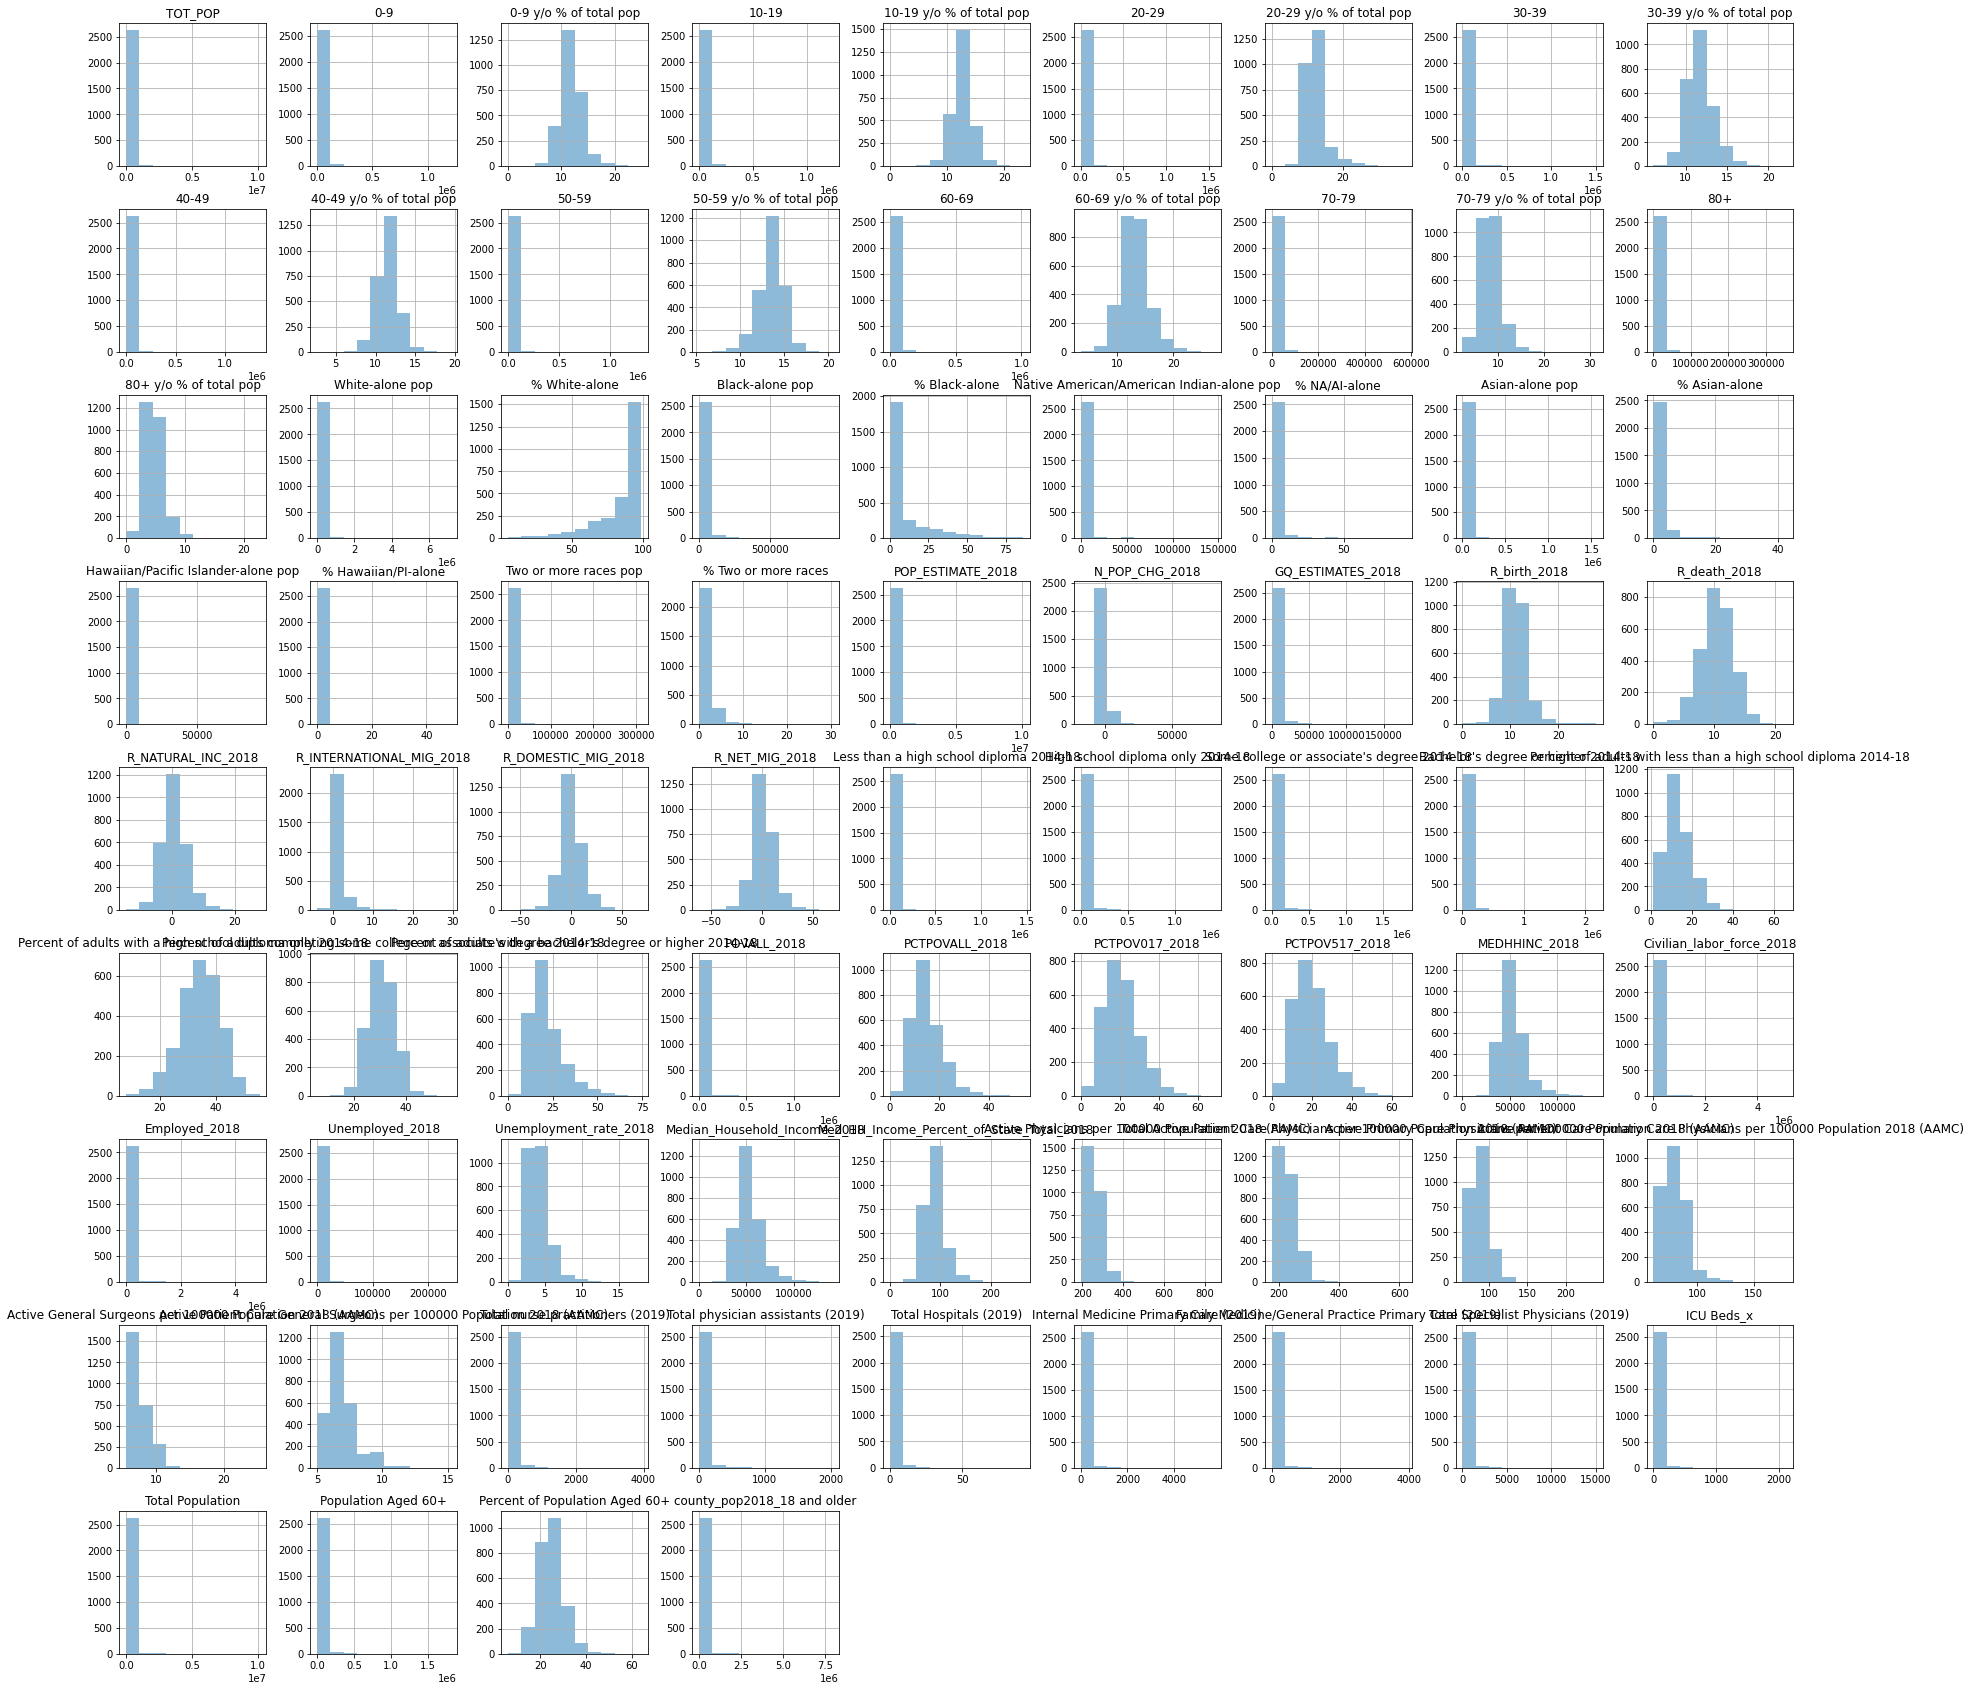

In [33]:
# histogramas univariados
X_train.hist(figsize = (30,30), alpha = 0.5)
plt.show()

Entre las variables hay cantidades absolutas y porcentajes, por lo que se observan algunas distribuciones univariadas de tipo campana y otras se concentran en muy pocos valores

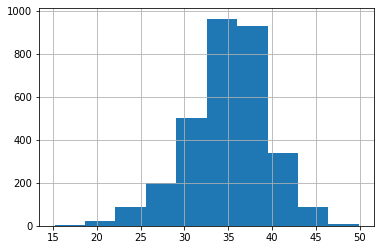

In [34]:
# histograma de la variable target
y.hist()
plt.show()


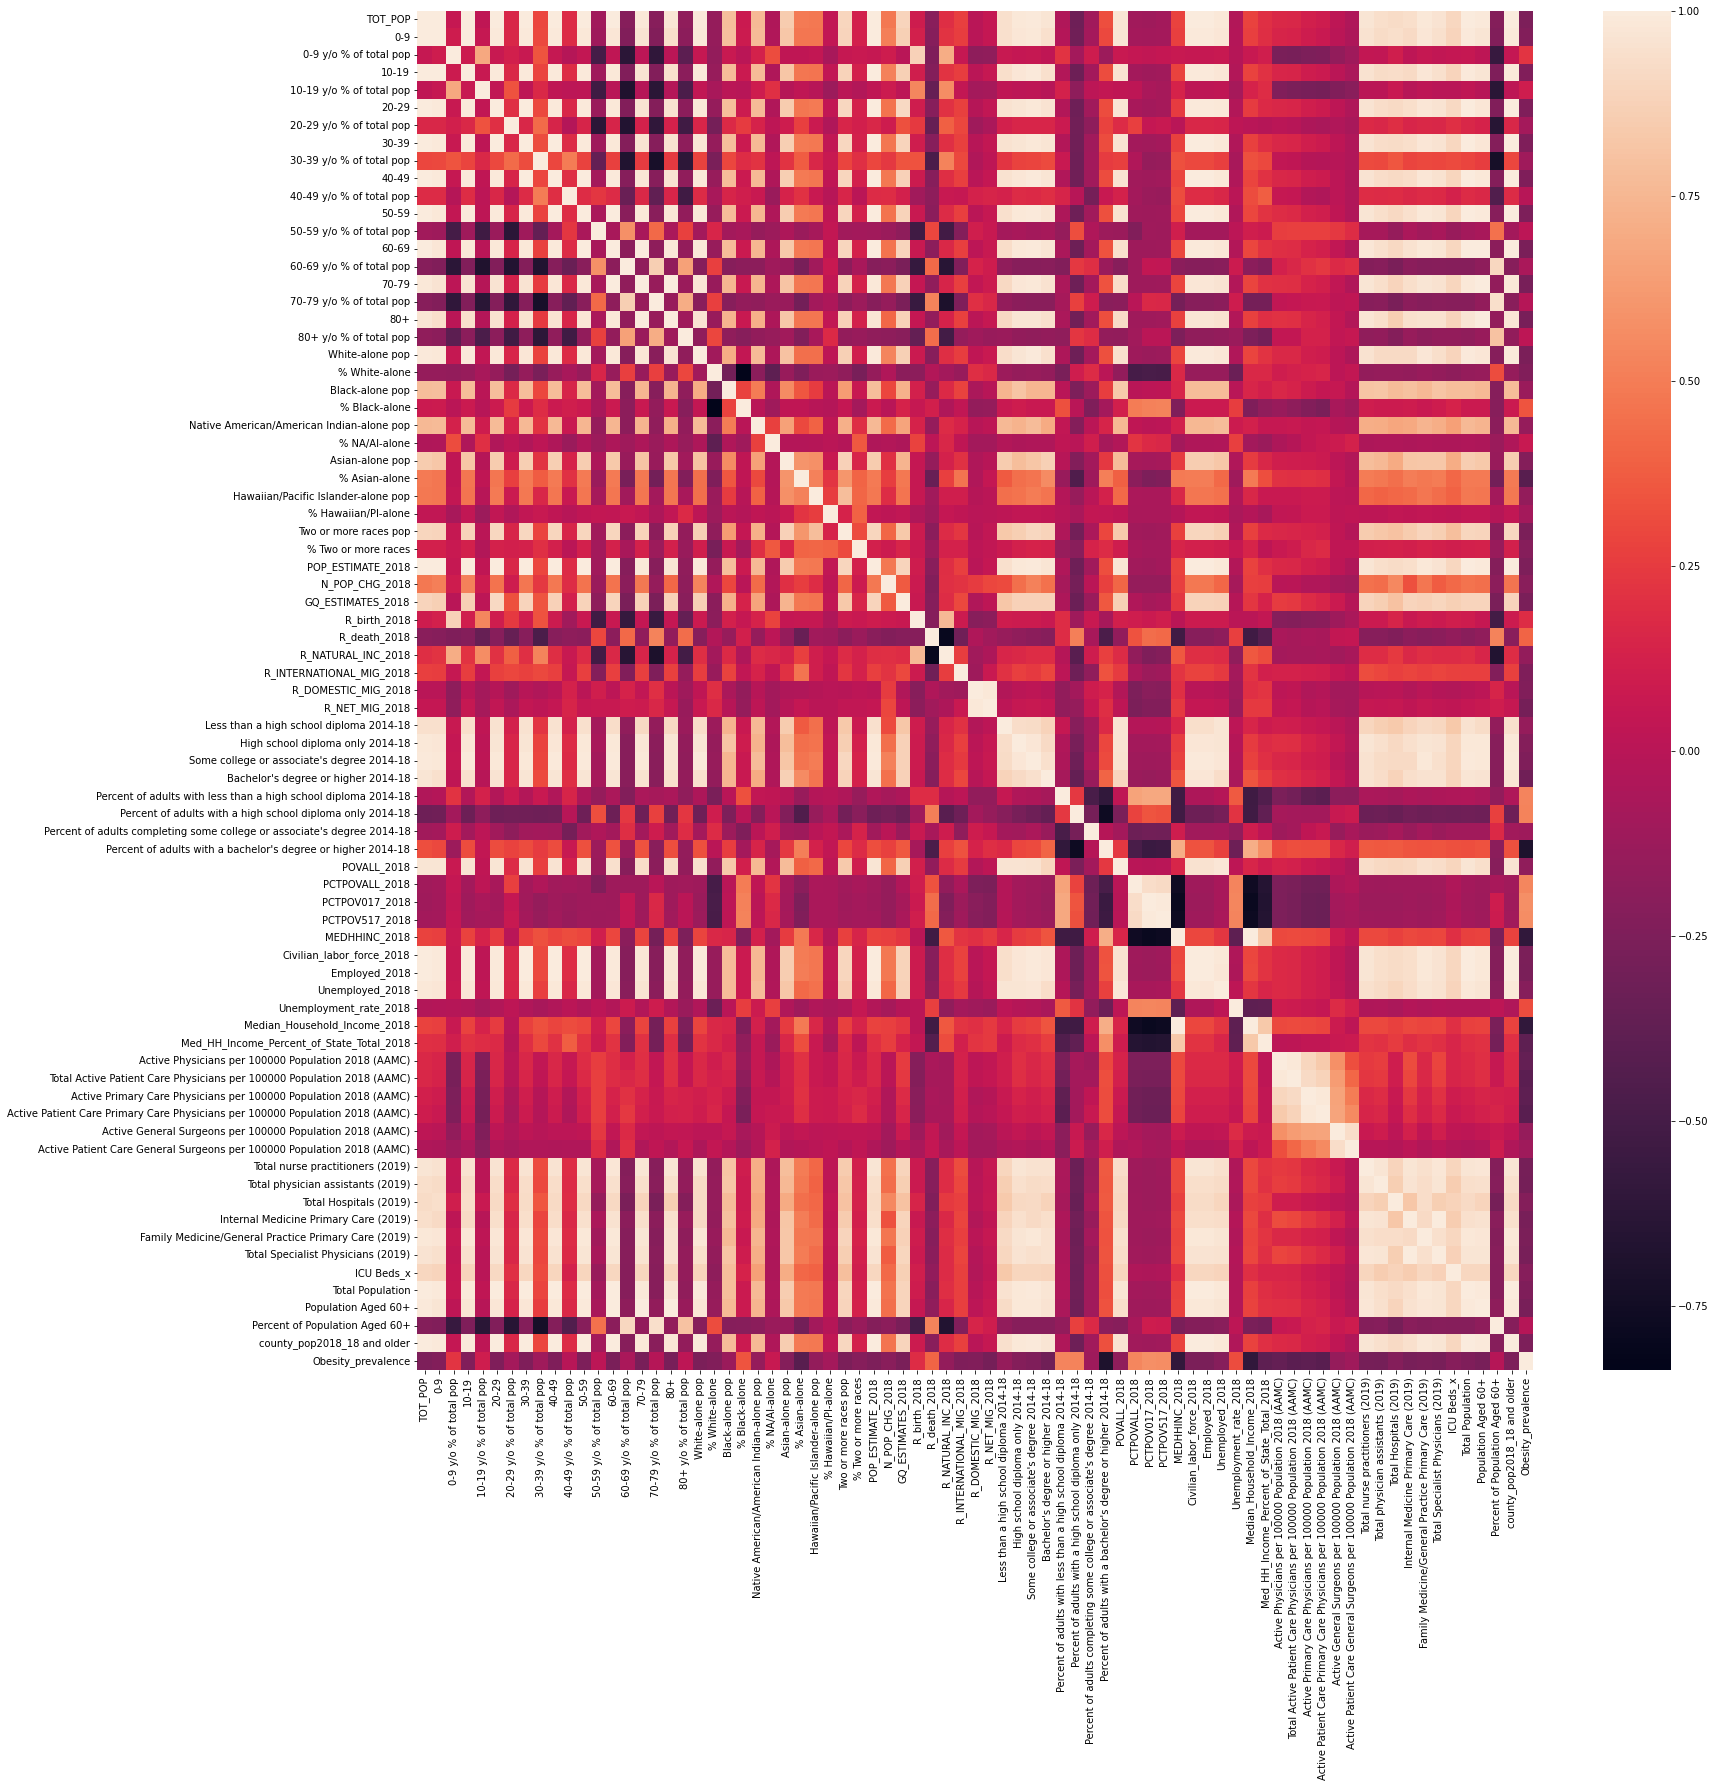

In [50]:
# matriz de correlaciones
plt.figure(figsize = (25,25))
corr_matrix = df_train.corr()
hit_map = sns.heatmap(corr_matrix, annot = False)
plt.show()

In [51]:
df_corr = pd.DataFrame(df_train.corrwith(df['Obesity_prevalence'], axis = 0), columns = ['Correlacion'])

In [52]:
df_corr[abs(df_corr['Correlacion']) > 0.5] # variables más correlacionadas con target

,Correlacion
Percent of adults with less than a high school diploma 2014-18,0.530000
Percent of adults with a high school diploma only 2014-18,0.523076
Percent of adults with a bachelor's degree or higher 2014-18,-0.692778
PCTPOVALL_2018,0.536102
PCTPOV017_2018,0.572900
PCTPOV517_2018,0.563669
MEDHHINC_2018,-0.593061
Median_Household_Income_2018,-0.593061
Obesity_prevalence,1.000000


**STEP 3:** Aplicar LASSO

In [53]:
# se convierten categóricas a dummy
X_train = pd.get_dummies(X_train, drop_first = True)
X_test = pd.get_dummies(X_test, drop_first = True)


In [60]:
# se estima LASSO inicial con alpha por defecto
mod = Lasso(normalize = True)
mod.fit(X_train, y_train)

/home/gitpod/.pyenv/versions/3.8.13/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(


Lasso(normalize=True)

In [61]:
# predicción con datos de test y error asociado
pred = mod.predict(X_test)
rmse_lasso = mean_squared_error(y_true = y_test, y_pred = pred, squared = False)
print("")
print(f"El error (rmse) de test es: {rmse_lasso}")


El error (rmse) de test es: 4.48529095925521


In [62]:
# Busco valor óptimo de alpha por cross validation
mods = LassoCV(alphas = np.logspace(-10, 3, 200), normalize = True, cv = 10)
mods.fit(X = X_train, y = y_train)

/home/gitpod/.pyenv/versions/3.8.13/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.415482325211997, tolerance: 4.796621449208993
  model = cd_fast.enet_coordinate_descent_gram(
/home/gitpod/.pyenv/versions/3.8.13/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.88932889454736, tolerance: 4.796621449208993
  model = cd_fast.enet_coordinate_descent_gram(
/home/gitpod/.pyenv/versions/3.8.13/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 104.1097773128713, tolerance: 4.796621449208993
  model = cd_fast.enet_coordinate_descent_gram(
/home/gitpod/.pyenv/versions/3

LassoCV(alphas=array([1.00000000e-10, 1.16232247e-10, 1.35099352e-10, 1.57029012e-10,
       1.82518349e-10, 2.12145178e-10, 2.46581108e-10, 2.86606762e-10,
       3.33129479e-10, 3.87203878e-10, 4.50055768e-10, 5.23109931e-10,
       6.08022426e-10, 7.06718127e-10, 8.21434358e-10, 9.54771611e-10,
       1.10975250e-09, 1.28989026e-09, 1.49926843e-09, 1.74263339e-09,
       2.02550194e-09, 2.35428641e-0...
       3.14403547e+01, 3.65438307e+01, 4.24757155e+01, 4.93704785e+01,
       5.73844165e+01, 6.66991966e+01, 7.75259749e+01, 9.01101825e+01,
       1.04737090e+02, 1.21738273e+02, 1.41499130e+02, 1.64467618e+02,
       1.91164408e+02, 2.22194686e+02, 2.58261876e+02, 3.00183581e+02,
       3.48910121e+02, 4.05546074e+02, 4.71375313e+02, 5.47890118e+02,
       6.36824994e+02, 7.40196000e+02, 8.60346442e+02, 1.00000000e+03]),
        cv=10, normalize=True)

In [65]:
# guardo los coeficientes de los distintos modelos de acuerdo al valor de alpha
alphas = mods.alphas_
coefs = []

for alpha in alphas:
    mod_temp = Lasso(alpha = alpha, fit_intercept = False, normalize = True)
    mod_temp.fit(X_train, y_train)
    coefs.append(mod_temp.coef_.flatten())

/home/gitpod/.pyenv/versions/3.8.13/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
/home/gitpod/.pyenv/versions/3.8.13/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing reg

`coefs` es una lista que contiene en cada entrada la lista de coeficientes para cada valor de alpha

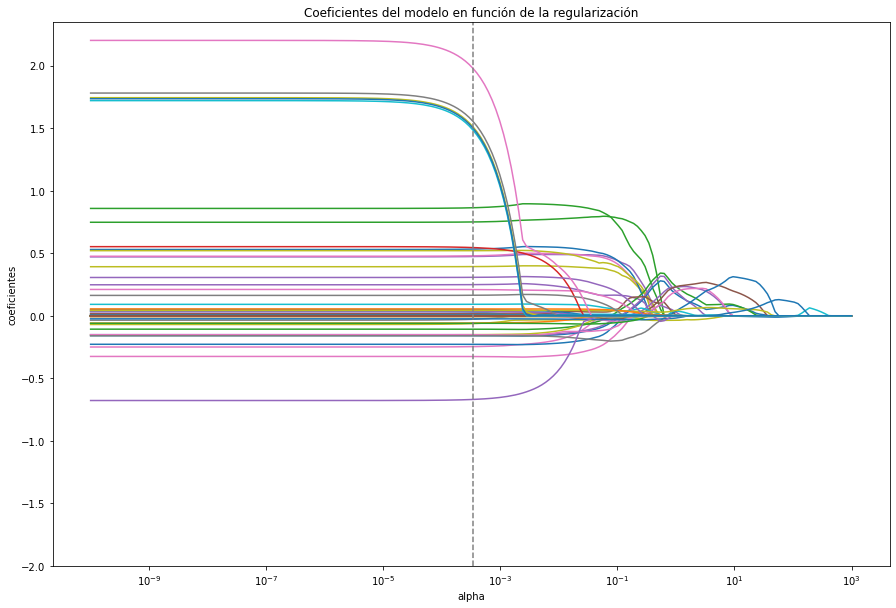

In [88]:
# grafico los coeficientes en función de alpha
fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(alphas, coefs)
ax.axvline(x = optimo, c = "gray", linestyle = '--', label = 'óptimo')
ax.set_xscale('log')
ax.set_ylim([-2,None])
ax.set_xlabel('alpha')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo en función de la regularización')
plt.show()

Hay coeficientes que son siempre positivos (independientemente de alpha), y otros son siempre negativos

In [74]:
# calculo error en función de alpha

mse_cv = mods.mse_path_.mean(axis=1)
mse_sd = mods.mse_path_.std(axis=1)

# Se aplica la raíz cuadrada para pasar de mse a rmse
rmse_cv = np.sqrt(mse_cv)
rmse_sd = np.sqrt(mse_sd)

# Se identifica el óptimo y el óptimo + 1std
min_rmse = np.min(rmse_cv)
sd_min_rmse = rmse_sd[np.argmin(rmse_cv)]
optimo = mods.alphas_[np.argmin(rmse_cv)]

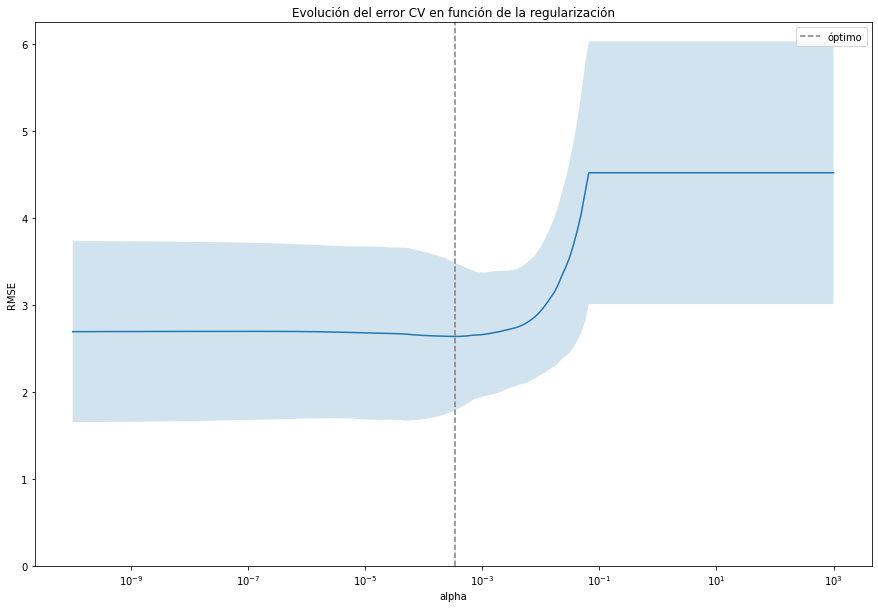

In [76]:
# Gráfico del error +- 1 desviación estándar
fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(mods.alphas_, rmse_cv)
ax.fill_between(mods.alphas_, rmse_cv + rmse_sd, rmse_cv - rmse_sd, alpha=0.2)
ax.axvline(x = optimo, c = "gray", linestyle = '--', label = 'óptimo')
ax.set_xscale('log')
ax.set_ylim([0,None])
ax.set_title('Evolución del error CV en función de la regularización')
ax.set_xlabel('alpha')
ax.set_ylabel('RMSE')
plt.legend()
plt.show()

In [77]:
print(f"Mejor valor de alpha encontrado: {mods.alpha_}")

Mejor valor de alpha encontrado: 0.0003409285069746815


In [79]:
# estimo LASSO con ese valor de alpha
alfa_optimo = mods.alpha_
mods_opt = Lasso(alpha = alfa_optimo, normalize = True)
mods_opt.fit(X_train, y_train)

/home/gitpod/.pyenv/versions/3.8.13/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(


Lasso(alpha=0.0003409285069746815, normalize=True)

In [85]:
# imprimo coeficientes del modelo óptimo
print(f'Los coeficientes estimados son: {mods_opt.coef_}')
print(f'Cantidad de variables seleccionadas: {sum(mods_opt.coef_!=0)}')
print(f'Cantidad de variables no seleccionadas: {sum(mods_opt.coef_==0)}')

Los coeficientes estimados son: [ 0.00000000e+00  0.00000000e+00  2.43615495e-01  0.00000000e+00
  5.34034769e-02 -0.00000000e+00 -7.77264089e-03  0.00000000e+00
 -0.00000000e+00  0.00000000e+00  4.54176310e-02  0.00000000e+00
  2.71096095e-01 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -3.34247678e-01 -1.37714325e-05  2.82991925e-01  0.00000000e+00
 -0.00000000e+00 -1.27157125e-07  4.99683185e-02 -3.33060431e-05
  0.00000000e+00  0.00000000e+00 -1.41180961e-01  8.83559222e-06
 -9.28742786e-02  0.00000000e+00 -5.34857877e-02  0.00000000e+00
  1.08854714e-06 -0.00000000e+00  0.00000000e+00  1.82273115e-01
 -0.00000000e+00 -0.00000000e+00 -2.45412153e-02 -3.80156808e-04
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00
  2.71956972e-02  1.71917115e-02 -0.00000000e+00 -1.77280409e-01
 -0.00000000e+00  7.20568812e-02  0.00000000e+00  0.00000000e+00
 -6.30973835e-05  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.90524415e-01 -0.00000000e+00  3.33892531e-02  1.898219

In [94]:
# data frame con nombre de la variable y su coeficiente
valor_coef = pd.DataFrame({'variable': mods_opt.feature_names_in_, 'coeficiente': mods_opt.coef_})
valor_coef

,variable,coeficiente
0,TOT_POP,0.000000
1,0-9,0.000000
2,0-9 y/o % of total pop,0.243615
3,10-19,0.000000
4,10-19 y/o % of total pop,0.053403
...,...,...
76,Urban_rural_code_2,0.513971
77,Urban_rural_code_3,0.034744
78,Urban_rural_code_4,-0.000000
79,Urban_rural_code_5,-0.000000


In [96]:
# variables seleccionadas
print(valor_coef[valor_coef.coeficiente != 0])

                                             variable   coeficiente
2                              0-9 y/o % of total pop  2.436155e-01
4                            10-19 y/o % of total pop  5.340348e-02
6                            20-29 y/o % of total pop -7.772641e-03
10                           40-49 y/o % of total pop  4.541763e-02
12                           50-59 y/o % of total pop  2.710961e-01
16                           70-79 y/o % of total pop -3.342477e-01
17                                                80+ -1.377143e-05
18                             80+ y/o % of total pop  2.829919e-01
21                                    Black-alone pop -1.271571e-07
22                                      % Black-alone  4.996832e-02
23          Native American/American Indian-alone pop -3.330604e-05
26                                      % Asian-alone -1.411810e-01
27                Hawaiian/Pacific Islander-alone pop  8.835592e-06
28                                % Hawaiian/PI-

In [97]:
# variables seleccionadas con coeficientes positivos: contribuyen a aumentar la prevalencia de la obesidad
print(valor_coef[valor_coef.coeficiente > 0])

                                             variable  coeficiente
2                              0-9 y/o % of total pop     0.243615
4                            10-19 y/o % of total pop     0.053403
10                           40-49 y/o % of total pop     0.045418
12                           50-59 y/o % of total pop     0.271096
18                             80+ y/o % of total pop     0.282992
22                                      % Black-alone     0.049968
27                Hawaiian/Pacific Islander-alone pop     0.000009
32                                     N_POP_CHG_2018     0.000001
35                                       R_death_2018     0.182273
44  Percent of adults with less than a high school...     0.027196
45  Percent of adults with a high school diploma o...     0.017192
49                                     PCTPOVALL_2018     0.072057
56                             Unemployment_rate_2018     0.190524
58          Med_HH_Income_Percent_of_State_Total_2018     0.03

In [98]:
# variables seleccionadas con coeficientes negativos: contribuyen a reducir la prevalencia de la obesidad
print(valor_coef[valor_coef.coeficiente < 0])

                                             variable   coeficiente
6                            20-29 y/o % of total pop -7.772641e-03
16                           70-79 y/o % of total pop -3.342477e-01
17                                                80+ -1.377143e-05
21                                    Black-alone pop -1.271571e-07
23          Native American/American Indian-alone pop -3.330604e-05
26                                      % Asian-alone -1.411810e-01
28                                % Hawaiian/PI-alone -9.287428e-02
30                                % Two or more races -5.348579e-02
38                                R_DOMESTIC_MIG_2018 -2.454122e-02
39                                     R_NET_MIG_2018 -3.801568e-04
47  Percent of adults with a bachelor's degree or ... -1.772804e-01
52                                      MEDHHINC_2018 -6.309738e-05
60  Total Active Patient Care Physicians per 10000... -4.060846e-02
62  Active Patient Care Primary Care Physicians 

Algunos resultados son ambiguos, no es clara la interpretación ern función de las variables explicativas utilizadas. Tal vez hubiese sido mejor utilizar otro target, porque para evaluar la prevalencia de la obesidad es muy importante considerar hábitos de alimentación y ejercicio que no se encontraban entre las variables predictoras.

**STEP 4:** Crear app.py, guardar el modelo y elaborar resumen del proceso

In [103]:
# se guardan datos de entrenamiento procesados
df_train.to_csv('../data/processed/datos_entrenamiento.csv', index = False)

In [102]:
# se guarda el modelo
filename = '../models/reg_model.sav'
pickle.dump(mods_opt, open(filename,'wb'))